# 4. Market Features Engineering

Create engineered features from market data and upload to Hopsworks.

**Pipeline**: Hopsworks FGs (raw) → Feature Engineering → Hopsworks FGs (engineered)

**Features Created**:
- **QQQ Technical**: Returns, volatility, RSI, moving average ratios
- **XLK Sector**: Sector returns, rolling correlation with QQQ
- **VIX Volatility**: VIX levels, changes, rolling statistics

**No Look-Ahead Bias**: All features use only past data (rolling windows, lagged returns)

In [34]:
import sys
sys.path.append('..')

import pandas as pd
from utils.feature_functions import (
    calculate_returns, calculate_rolling_volatility, calculate_rsi,
    calculate_ma_ratios, calculate_rolling_correlation
)
from utils.hopsworks_helpers import get_feature_store, create_feature_group
from dotenv import load_dotenv
import yaml

load_dotenv()

# Load config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

## Connect to Hopsworks and Load Raw Data

**Diagnostic Mode**: We'll inspect the feature group schema and try multiple read methods to identify the root cause of the Arrow Flight error. If Hopsworks read fails, we'll automatically fall back to Yahoo Finance.

In [35]:
# Connect to Hopsworks
print("Connecting to Hopsworks...")
fs = get_feature_store()
print(f"✓ Connected to feature store: {fs.name}")

Connecting to Hopsworks...
2026-01-05 12:38:55,492 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-05 12:38:55,495 INFO: Initializing external client
2026-01-05 12:38:55,496 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 12:38:56,706 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272010
✓ Connected to feature store: scalable_lab1_featurestore


## Diagnostic: Inspect Feature Group Schema

In [36]:
# Get feature group metadata to diagnose the issue
print("Getting feature group metadata...")
qqq_fg = fs.get_feature_group('qqq_raw', version=1)

print(f"\n✓ Feature group retrieved: {qqq_fg.name}")
print(f"  Version: {qqq_fg.version}")
print(f"  Primary keys: {qqq_fg.primary_key}")
print(f"  Event time: {qqq_fg.event_time}")

# Inspect schema
print(f"\nSchema inspection:")
print(f"  Features: {qqq_fg.features}")
print(f"  Number of features: {len(qqq_fg.features)}")

# Print detailed feature info
print(f"\nDetailed feature information:")
for feature in qqq_fg.features:
    print(f"  - {feature.name}: {feature.type} (primary: {feature.primary})")

# Check available read methods
print(f"\nAvailable methods on feature group:")
methods = [m for m in dir(qqq_fg) if not m.startswith('_') and callable(getattr(qqq_fg, m))]
read_methods = [m for m in methods if 'read' in m.lower()]
print(f"  Read-related methods: {read_methods}")

Getting feature group metadata...

✓ Feature group retrieved: qqq_raw
  Version: 1
  Primary keys: ['date']
  Event time: date

Schema inspection:
  Features: [Feature('date', 'timestamp', None, True, False, False, None, None, 1876538), Feature('qqq_open', 'double', None, False, False, False, None, None, 1876538), Feature('qqq_high', 'double', None, False, False, False, None, None, 1876538), Feature('qqq_low', 'double', None, False, False, False, None, None, 1876538), Feature('qqq_close', 'double', None, False, False, False, None, None, 1876538), Feature('qqq_volume', 'bigint', None, False, False, False, None, None, 1876538)]
  Number of features: 6

Detailed feature information:
  - date: timestamp (primary: True)
  - qqq_open: double (primary: False)
  - qqq_high: double (primary: False)
  - qqq_low: double (primary: False)
  - qqq_close: double (primary: False)
  - qqq_volume: bigint (primary: False)

Available methods on feature group:


  Read-related methods: ['read', 'read_changes']


## Try Alternative Read Methods

In [37]:
# Try different read approaches to bypass Arrow Flight bug

print("Attempting Method 1: Default read()...")
try:
    qqq_df = qqq_fg.read()
    print(f"✓ SUCCESS with read(): {qqq_df.shape}")
except Exception as e:
    print(f"✗ FAILED with read(): {type(e).__name__}")
    print(f"  Error: {str(e)[:200]}...")
    
    print("\nAttempting Method 2: read() with read_options...")
    try:
        qqq_df = qqq_fg.read(read_options={"use_hive": True})
        print(f"✓ SUCCESS with read(use_hive=True): {qqq_df.shape}")
    except Exception as e2:
        print(f"✗ FAILED with read_options: {type(e2).__name__}")
        print(f"  Error: {str(e2)[:200]}...")
        
        print("\nAttempting Method 3: select_all().read()...")
        try:
            qqq_df = qqq_fg.select_all().read()
            print(f"✓ SUCCESS with select_all().read(): {qqq_df.shape}")
        except Exception as e3:
            print(f"✗ FAILED with select_all(): {type(e3).__name__}")
            print(f"  Error: {str(e3)[:200]}...")
            
            print("\nAttempting Method 4: select specific columns...")
            try:
                # Select columns explicitly by name (not metadata)
                col_names = [f.name for f in qqq_fg.features]
                print(f"  Column names: {col_names}")
                query = qqq_fg.select(col_names)
                qqq_df = query.read()
                print(f"✓ SUCCESS with explicit column select: {qqq_df.shape}")
            except Exception as e4:
                print(f"✗ FAILED with explicit select: {type(e4).__name__}")
                print(f"  Error: {str(e4)[:200]}...")
                
                print("\n❌ ALL READ METHODS FAILED")
                print("\nFalling back to Yahoo Finance direct fetch...")
                from utils.data_fetchers import fetch_yahoo_data
                qqq_df = fetch_yahoo_data('QQQ', config['data']['start_date'], config['data']['end_date'])
                qqq_df = qqq_df.rename(columns={
                    'open': 'qqq_open', 'high': 'qqq_high', 'low': 'qqq_low',
                    'close': 'qqq_close', 'volume': 'qqq_volume'
                })
                print(f"✓ Fetched from Yahoo Finance: {qqq_df.shape}")

Attempting Method 1: Default read()...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 
✓ SUCCESS with read(): (1506, 6)


In [38]:
# Repeat for XLK and VIX using the same approach
print("\n" + "="*60)
print("Fetching XLK data...")
print("="*60)

xlk_fg = fs.get_feature_group('xlk_raw', version=1)
try:
    xlk_df = xlk_fg.read()
    print(f"✓ XLK read successful: {xlk_df.shape}")
except:
    from utils.data_fetchers import fetch_yahoo_data
    xlk_df = fetch_yahoo_data('XLK', config['data']['start_date'], config['data']['end_date'])
    xlk_df = xlk_df.rename(columns={
        'open': 'xlk_open', 'high': 'xlk_high', 'low': 'xlk_low',
        'close': 'xlk_close', 'volume': 'xlk_volume'
    })
    print(f"✓ XLK fetched from Yahoo Finance: {xlk_df.shape}")

print("\n" + "="*60)
print("Fetching VIX data...")
print("="*60)

vix_fg = fs.get_feature_group('vix_raw', version=1)
try:
    vix_df = vix_fg.read()
    print(f"✓ VIX read successful: {vix_df.shape}")
except:
    from utils.data_fetchers import fetch_yahoo_data
    vix_df = fetch_yahoo_data('^VIX', config['data']['start_date'], config['data']['end_date'])
    vix_df = vix_df.rename(columns={
        'open': 'vix_open', 'high': 'vix_high', 'low': 'vix_low',
        'close': 'vix_close', 'volume': 'vix_volume'
    })
    print(f"✓ VIX fetched from Yahoo Finance: {vix_df.shape}")

print("\n" + "="*60)
print("Summary: All data loaded successfully")
print("="*60)
print(f"QQQ: {qqq_df.shape}")
print(f"XLK: {xlk_df.shape}")
print(f"VIX: {vix_df.shape}")


Fetching XLK data...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.66s) 
✓ XLK read successful: (1506, 6)

Fetching VIX data...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 
✓ VIX read successful: (1506, 6)

Summary: All data loaded successfully
QQQ: (1506, 6)
XLK: (1506, 6)
VIX: (1506, 6)


In [39]:
# Verify data alignment
print("\nDate ranges:")
print(f"QQQ: {qqq_df['date'].min()} to {qqq_df['date'].max()}")
print(f"XLK: {xlk_df['date'].min()} to {xlk_df['date'].max()}")
print(f"VIX: {vix_df['date'].min()} to {vix_df['date'].max()}")


Date ranges:
QQQ: 2020-01-02 00:00:00+00:00 to 2025-12-29 00:00:00+00:00
XLK: 2020-01-02 00:00:00+00:00 to 2025-12-29 00:00:00+00:00
VIX: 2020-01-02 00:00:00+00:00 to 2025-12-29 00:00:00+00:00


## QQQ Technical Features

Create technical indicators for QQQ ETF:
- **Returns**: Multi-period returns (1d, 2d, 3d, 5d)
- **Volatility**: Rolling standard deviation of returns (5d, 10d, 20d)
- **RSI**: Relative Strength Index (14-day)
- **MA Ratios**: Price / Moving Average ratios (10d, 20d, 50d)

In [40]:
print("Creating QQQ technical features...")

# Start with base data
qqq_features = qqq_df.copy()

# Calculate returns
qqq_features = calculate_returns(
    qqq_features, 
    price_col='qqq_close',
    periods=config['features']['technical']['return_lags']
)

# Calculate rolling volatility
qqq_features = calculate_rolling_volatility(
    qqq_features,
    price_col='qqq_close',
    windows=config['features']['technical']['volatility_windows']
)

# Calculate RSI
qqq_features = calculate_rsi(
    qqq_features,
    price_col='qqq_close',
    period=config['features']['technical']['rsi_period']
)

# Calculate MA ratios
qqq_features = calculate_ma_ratios(
    qqq_features,
    price_col='qqq_close',
    periods=config['features']['technical']['ma_periods']
)

print(f"\nQQQ features shape: {qqq_features.shape}")
print(f"Feature columns added: {[col for col in qqq_features.columns if col.startswith(('return_', 'volatility_', 'rsi_', 'ma_ratio_'))]}")

Creating QQQ technical features...

QQQ features shape: (1506, 17)
Feature columns added: ['return_1d', 'return_2d', 'return_3d', 'return_5d', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'rsi_14', 'ma_ratio_10', 'ma_ratio_20', 'ma_ratio_50']


In [41]:
# Preview QQQ features
#feature_cols = ['date'] + [col for col in qqq_features.columns if col.startswith(('return_', 'volatility_', 'rsi_', 'ma_ratio_'))]
#qqq_features[feature_cols].head(20)

# Preview QQQ features chronological order
feature_cols = ['date'] + [
    col for col in qqq_features.columns
    if col.startswith(('return_', 'volatility_', 'rsi_', 'ma_ratio_'))
]

qqq_features_sorted = (
    qqq_features
    .assign(date=pd.to_datetime(qqq_features['date']))  # sicurezza
    .sort_values('date')                                # ordine cronologico crescente
)

qqq_features_sorted[feature_cols].head(20)

,date,return_1d,return_2d,return_3d,return_5d,volatility_5d,volatility_10d,volatility_20d,rsi_14,ma_ratio_10,ma_ratio_20,ma_ratio_50
1031,2020-01-02 00:00:00+00:00,-0.312600,-0.320703,-0.344066,-0.253869,0.168737,0.214190,0.223932,39.744744,0.736061,0.754731,0.732714
914,2020-01-03 00:00:00+00:00,-0.467807,-0.179788,-0.451805,-0.348329,0.405980,0.363834,0.293018,45.315052,0.662576,0.659625,0.681302
817,2020-01-06 00:00:00+00:00,-0.230530,-0.411074,-0.348997,-0.209279,0.207737,0.235257,0.220148,48.595304,0.737148,0.777116,0.735914
1396,2020-01-07 00:00:00+00:00,-0.336795,-0.465592,-0.293700,-0.435253,0.266027,0.362814,0.287086,45.831446,0.712399,0.688648,0.694551
1296,2020-01-08 00:00:00+00:00,-0.237801,-0.399778,-0.249958,-0.243294,0.288654,0.253623,0.240477,40.684366,0.741569,0.709044,0.688819
1317,2020-01-09 00:00:00+00:00,-0.155753,-0.044546,-0.445340,-0.343329,0.254060,0.186737,0.154277,40.637760,0.731776,0.732942,0.719584
1163,2020-01-10 00:00:00+00:00,-0.266824,-0.273481,-0.311503,-0.309225,0.309780,0.242263,0.289100,41.457526,0.738790,0.713609,0.698784
1270,2020-01-13 00:00:00+00:00,-0.396502,-0.324875,-0.266146,-0.220204,0.221941,0.179592,0.271657,39.923637,0.699469,0.691373,0.712165
1087,2020-01-14 00:00:00+00:00,-0.343845,-0.193850,-0.291065,-0.169580,0.229640,0.177046,0.138382,44.749074,0.715678,0.715937,0.718123
882,2020-01-15 00:00:00+00:00,-0.363426,-0.209887,-0.257352,-0.210993,0.224720,0.184669,0.265291,45.882264,0.728929,0.728438,0.737431


In [42]:
# Check for missing values
print("\nMissing values in QQQ features:")
print(qqq_features[feature_cols].isnull().sum())
print(f"\nRows with any NaN: {qqq_features[feature_cols].isnull().any(axis=1).sum()} (expected due to rolling windows)")


Missing values in QQQ features:
date               0
return_1d          1
return_2d          2
return_3d          3
return_5d          5
volatility_5d      5
volatility_10d    10
volatility_20d    20
rsi_14            13
ma_ratio_10        9
ma_ratio_20       19
ma_ratio_50       49
dtype: int64

Rows with any NaN: 49 (expected due to rolling windows)


## XLK Sector Features

Create sector-specific features:
- **XLK Returns**: Technology sector returns
- **Rolling Correlation**: QQQ-XLK correlation (20d, 60d windows)

In [43]:
print("Creating XLK sector features...")

# Calculate XLK returns
xlk_features = calculate_returns(
    xlk_df,
    price_col='xlk_close',
    periods=[1, 5]  # 1-day and 5-day returns
)

# Calculate rolling correlation between QQQ and XLK
correlation_df = calculate_rolling_correlation(
    qqq_df,
    xlk_df,
    col1='qqq_close',
    col2='xlk_close',
    windows=config['features']['sector']['correlation_windows']
)

# Merge XLK features with correlation
xlk_features = xlk_features.merge(correlation_df, on='date', how='left')

print(f"\nXLK features shape: {xlk_features.shape}")
print(f"Feature columns: {[col for col in xlk_features.columns if col.startswith(('return_', 'corr_'))]}")

Creating XLK sector features...

XLK features shape: (1506, 10)
Feature columns: ['return_1d', 'return_5d', 'corr_20d', 'corr_60d']


In [44]:
# Preview XLK features
#xlk_cols = ['date'] + [col for col in xlk_features.columns if col.startswith(('return_', 'corr_'))]
#xlk_features[xlk_cols].head(20)

# Preview XLK features ordinate per data
xlk_cols = ['date'] + [
    col for col in xlk_features.columns
    if col.startswith(('return_', 'corr_'))
]

xlk_features_sorted = (
    xlk_features
    .assign(date=pd.to_datetime(xlk_features['date']))  # sicurezza
    .sort_values('date')                                # ordine cronologico
)

xlk_features_sorted[xlk_cols].head(20)

,date,return_1d,return_5d,corr_20d,corr_60d
1031,2020-01-02 00:00:00+00:00,-0.293365,-0.234095,0.977282,0.975188
914,2020-01-03 00:00:00+00:00,-0.467370,-0.330777,0.982860,0.977443
817,2020-01-06 00:00:00+00:00,-0.211590,-0.195865,0.976195,0.979294
1396,2020-01-07 00:00:00+00:00,-0.382164,-0.448317,0.988319,0.980598
1296,2020-01-08 00:00:00+00:00,-0.221501,-0.224084,0.971250,0.975333
1317,2020-01-09 00:00:00+00:00,-0.124076,-0.378529,0.967988,0.975760
1163,2020-01-10 00:00:00+00:00,-0.324528,-0.281477,0.975538,0.971812
1270,2020-01-13 00:00:00+00:00,-0.410214,-0.198142,0.988694,0.971674
1087,2020-01-14 00:00:00+00:00,-0.312498,-0.130314,0.951447,0.969246
882,2020-01-15 00:00:00+00:00,-0.387895,-0.179323,0.968189,0.978300


In [45]:
# Summary statistics for XLK correlation
print("\nXLK-QQQ Correlation Statistics:")
xlk_features[[col for col in xlk_features.columns if col.startswith('corr_')]].describe()


XLK-QQQ Correlation Statistics:


,corr_20d,corr_60d
count,1487.000000,1447.000000
mean,0.983395,0.984988
std,0.014533,0.010488
min,0.912569,0.960316
25%,0.974497,0.974910
50%,0.989104,0.991539
75%,0.994883,0.994836
max,0.998972,0.997140


## VIX Volatility Features

Create volatility regime features:
- **VIX Close**: Current volatility level
- **VIX Change**: Absolute and percentage changes
- **VIX Rolling Stats**: 20-day moving average and standard deviation

In [46]:
print("Creating VIX volatility features...")

# Calculate VIX changes and rolling stats
vix_features = vix_df.copy()
vix_features['vix_change'] = vix_features['vix_close'].diff()
vix_features['vix_pct_change'] = vix_features['vix_close'].pct_change()

# Rolling statistics
vix_features['vix_ma_20'] = vix_features['vix_close'].rolling(20).mean()
vix_features['vix_std_20'] = vix_features['vix_close'].rolling(20).std()

# VIX relative to moving average (regime indicator)
vix_features['vix_ma_ratio'] = vix_features['vix_close'] / vix_features['vix_ma_20']

print(f"\nVIX features shape: {vix_features.shape}")
print(f"Feature columns: {[col for col in vix_features.columns if col.startswith('vix_') and col != 'vix_open' and col != 'vix_high' and col != 'vix_low' and col != 'vix_volume']}")

Creating VIX volatility features...

VIX features shape: (1506, 11)
Feature columns: ['vix_close', 'vix_change', 'vix_pct_change', 'vix_ma_20', 'vix_std_20', 'vix_ma_ratio']


In [47]:
# Preview VIX features
#vix_cols = ['date', 'vix_close', 'vix_change', 'vix_pct_change', 'vix_ma_20', 'vix_std_20', 'vix_ma_ratio']
#vix_features[vix_cols].head(20)

# Preview VIX features ordinate per data
vix_cols = [
    'date', 'vix_close', 'vix_change', 'vix_pct_change',
    'vix_ma_20', 'vix_std_20', 'vix_ma_ratio'
]

vix_features_sorted = (
    vix_features
    .assign(date=pd.to_datetime(vix_features['date']))  # sicurezza
    .sort_values('date')                                # ordine cronologico
)

vix_features_sorted[vix_cols].head(20)

,date,vix_close,vix_change,vix_pct_change,vix_ma_20,vix_std_20,vix_ma_ratio
1031,2020-01-02 00:00:00+00:00,12.470000,-9.230000,-0.425346,26.7670,7.706854,0.465872
914,2020-01-03 00:00:00+00:00,14.020000,-4.559999,-0.245425,23.7370,6.208221,0.590639
817,2020-01-06 00:00:00+00:00,13.850000,-11.740000,-0.458773,26.5480,11.894238,0.521697
1396,2020-01-07 00:00:00+00:00,13.790000,-7.990001,-0.366850,22.5840,5.799336,0.610609
1296,2020-01-08 00:00:00+00:00,13.450000,-15.730000,-0.539068,23.4220,7.107894,0.574246
1318,2020-01-09 00:00:00+00:00,12.540000,-6.630000,-0.345853,23.6930,6.045953,0.529270
1163,2020-01-10 00:00:00+00:00,12.560000,-8.020000,-0.389699,23.7190,6.450342,0.529533
1270,2020-01-13 00:00:00+00:00,12.320000,-7.309999,-0.372389,23.5125,7.367364,0.523977
1087,2020-01-14 00:00:00+00:00,12.390000,-9.239999,-0.427184,24.1620,5.621956,0.512789
882,2020-01-15 00:00:00+00:00,12.420000,-18.059999,-0.592520,26.6650,12.899218,0.465779


In [48]:
# VIX regime analysis
print("\nVIX Regime Analysis:")
print(f"VIX range: {vix_features['vix_close'].min():.2f} to {vix_features['vix_close'].max():.2f}")
print(f"VIX mean: {vix_features['vix_close'].mean():.2f}")
print(f"\nDays with VIX > 30 (high volatility): {(vix_features['vix_close'] > 30).sum()}")
print(f"Days with VIX < 15 (low volatility): {(vix_features['vix_close'] < 15).sum()}")


VIX Regime Analysis:
VIX range: 11.86 to 82.69
VIX mean: 21.01

Days with VIX > 30 (high volatility): 147
Days with VIX < 15 (low volatility): 277


## Visualize Key Features

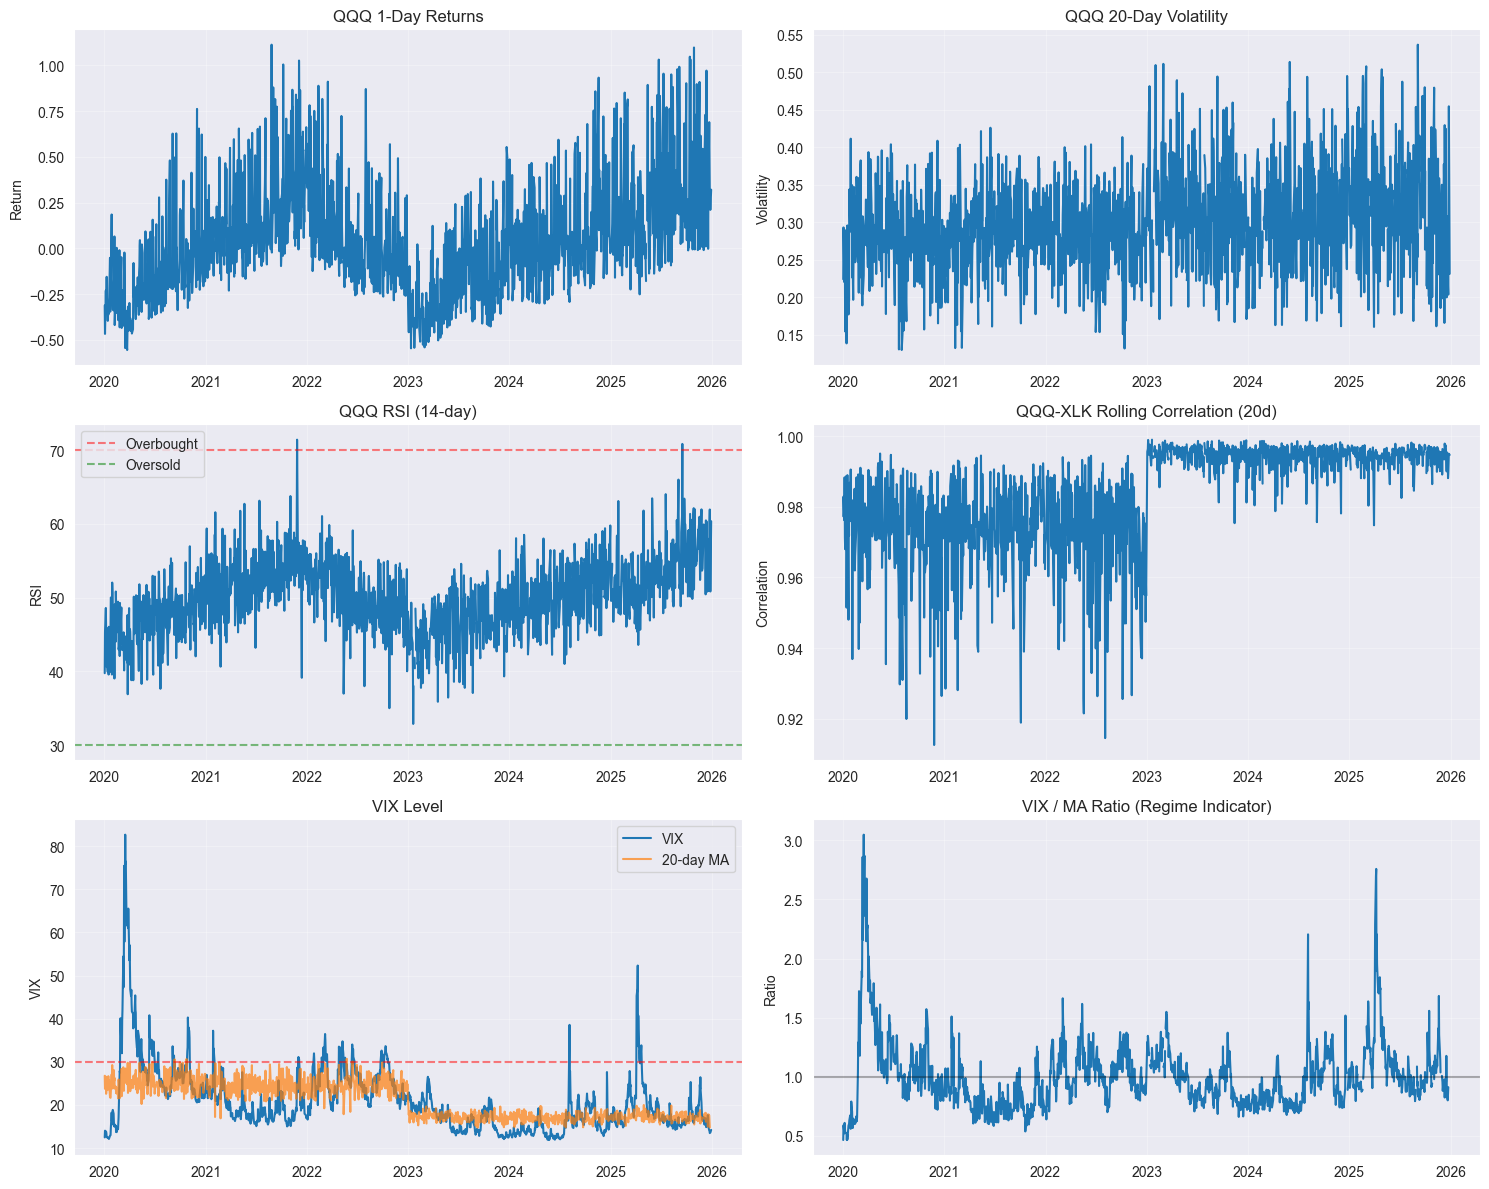


✓ Feature distributions look reasonable


In [49]:
import matplotlib.pyplot as plt

# Ensure datetime + chronological order
for df in [qqq_features, xlk_features, vix_features]:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.reset_index(drop=True, inplace=True)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# QQQ returns
axes[0, 0].plot(qqq_features['date'], qqq_features['return_1d'])
axes[0, 0].set_title('QQQ 1-Day Returns')
axes[0, 0].set_ylabel('Return')
axes[0, 0].grid(True, alpha=0.3)

# QQQ volatility
axes[0, 1].plot(qqq_features['date'], qqq_features['volatility_20d'])
axes[0, 1].set_title('QQQ 20-Day Volatility')
axes[0, 1].set_ylabel('Volatility')
axes[0, 1].grid(True, alpha=0.3)

# RSI
axes[1, 0].plot(qqq_features['date'], qqq_features['rsi_14'])
axes[1, 0].axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought')
axes[1, 0].axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold')
axes[1, 0].set_title('QQQ RSI (14-day)')
axes[1, 0].set_ylabel('RSI')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# QQQ-XLK correlation
axes[1, 1].plot(xlk_features['date'], xlk_features['corr_20d'])
axes[1, 1].set_title('QQQ-XLK Rolling Correlation (20d)')
axes[1, 1].set_ylabel('Correlation')
axes[1, 1].grid(True, alpha=0.3)

# VIX level
axes[2, 0].plot(vix_features['date'], vix_features['vix_close'], label='VIX')
axes[2, 0].plot(vix_features['date'], vix_features['vix_ma_20'], label='20-day MA', alpha=0.7)
axes[2, 0].axhline(y=30, color='r', linestyle='--', alpha=0.5)
axes[2, 0].set_title('VIX Level')
axes[2, 0].set_ylabel('VIX')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# VIX regime indicator
axes[2, 1].plot(vix_features['date'], vix_features['vix_ma_ratio'])
axes[2, 1].axhline(y=1.0, color='k', linestyle='-', alpha=0.3)
axes[2, 1].set_title('VIX / MA Ratio (Regime Indicator)')
axes[2, 1].set_ylabel('Ratio')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Feature distributions look reasonable")

## Upload Market Features to Hopsworks

In [50]:
# Select relevant columns for feature groups
print("\nPreparing feature groups for upload...")

# QQQ technical features only (exclude OHLCV)
qqq_cols = ['date'] + [col for col in qqq_features.columns if col.startswith(('return_', 'volatility_', 'rsi_', 'ma_ratio_'))]
qqq_features_final = qqq_features[qqq_cols].copy()

# XLK sector features only
xlk_cols = ['date'] + [col for col in xlk_features.columns if col.startswith(('return_', 'corr_'))]
xlk_features_final = xlk_features[xlk_cols].copy()

# VIX volatility features
vix_cols = ['date', 'vix_close', 'vix_change', 'vix_pct_change', 'vix_ma_20', 'vix_std_20', 'vix_ma_ratio']
vix_features_final = vix_features[vix_cols].copy()

print(f"QQQ features to upload: {len(qqq_cols)-1} columns, {qqq_features_final.shape[0]} rows")
print(f"XLK features to upload: {len(xlk_cols)-1} columns, {xlk_features_final.shape[0]} rows")
print(f"VIX features to upload: {len(vix_cols)-1} columns, {vix_features_final.shape[0]} rows")


Preparing feature groups for upload...
QQQ features to upload: 11 columns, 1506 rows
XLK features to upload: 4 columns, 1506 rows
VIX features to upload: 6 columns, 1506 rows


In [51]:
# Upload QQQ technical features
print("\nUploading QQQ technical features to Hopsworks...")
qqq_fg = create_feature_group(
    fs,
    name='qqq_technical_features',
    df=qqq_features_final,
    primary_key=['date'],
    description='QQQ technical indicators: returns, volatility, RSI, MA ratios'
)
print(f"✓ Created feature group: qqq_technical_features (version {qqq_fg.version})")


Uploading QQQ technical features to Hopsworks...

Creating feature group: qqq_technical_features
Data shape (before deduplication): (1506, 12)
Data shape (after deduplication): (1506, 12)
Columns: ['date', 'return_1d', 'return_2d', 'return_3d', 'return_5d', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'rsi_14', 'ma_ratio_10', 'ma_ratio_20', 'ma_ratio_50']
Data types:
date              datetime64[ms]
return_1d                float64
return_2d                float64
return_3d                float64
return_5d                float64
volatility_5d            float64
volatility_10d           float64
volatility_20d           float64
rsi_14                   float64
ma_ratio_10              float64
ma_ratio_20              float64
ma_ratio_50              float64
dtype: object
✓ Feature group 'qqq_technical_features' already exists (version 1)
  Feature group object type: <class 'hsfs.feature_group.FeatureGroup'>
  Deleting existing data and re-inserting...

Inserting 1506 rows...
Sam

Uploading Dataframe: 100.00% |██████████| Rows 1506/1506 | Elapsed Time: 00:00 | Remaining Time: 00:00
Use fg.materialization_job.run(args=-op offline_fg_materialization -path hdfs:///Projects/Scalable_Lab1/Resources/jobs/qqq_technical_features_1_offline_fg_materialization/config_1767364432503) to trigger the materialization job again.


✓ Insert job completed
  Job details: (Job('qqq_technical_features_1_offline_fg_materialization', 'SPARK'), None)

Waiting for data to be committed (10 seconds)...

✓ Upload completed successfully
  Job finished with status: SUCCEEDED
  Uploaded 1506 rows to 'qqq_technical_features'

⚠️  NOTE: Data is in Hopsworks but may take a few minutes to be queryable
   Check the Hopsworks UI to see the data in the feature group

✓ Created feature group: qqq_technical_features (version 1)


In [52]:
# Upload XLK sector features
print("\nUploading XLK sector features to Hopsworks...")
xlk_fg = create_feature_group(
    fs,
    name='xlk_sector_features',
    df=xlk_features_final,
    primary_key=['date'],
    description='XLK sector features: returns and rolling correlation with QQQ'
)
print(f"✓ Created feature group: xlk_sector_features (version {xlk_fg.version})")


Uploading XLK sector features to Hopsworks...

Creating feature group: xlk_sector_features
Data shape (before deduplication): (1506, 5)
Data shape (after deduplication): (1506, 5)
Columns: ['date', 'return_1d', 'return_5d', 'corr_20d', 'corr_60d']
Data types:
date         datetime64[ms]
return_1d           float64
return_5d           float64
corr_20d            float64
corr_60d            float64
dtype: object
✓ Feature group 'xlk_sector_features' already exists (version 1)
  Feature group object type: <class 'hsfs.feature_group.FeatureGroup'>
  Deleting existing data and re-inserting...

Inserting 1506 rows...
Sample data (first row):
[{'date': Timestamp('2020-01-02 00:00:00'), 'return_1d': -0.29336529123454835, 'return_5d': -0.23409468472189165, 'corr_20d': 0.9772820886344695, 'corr_60d': 0.9751883340607709}]


Uploading Dataframe: 100.00% |██████████| Rows 1506/1506 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: xlk_sector_features_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272010/jobs/named/xlk_sector_features_1_offline_fg_materialization/executions
2026-01-05 12:40:15,784 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2026-01-05 12:40:19,002 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2026-01-05 12:40:22,210 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-05 12:41:55,745 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2026-01-05 12:41:55,910 INFO: Waiting for log aggregation to finish.
2026-01-05 12:42:04,546 INFO: Execution finished successfully.
✓ Insert job completed
  Job details: (Job('xlk_sector_features_1_offline_fg_materialization', 'SPARK'), None)

Waiting for data to be committed (10 seconds)...

✓ Upload com

In [53]:
# Upload VIX volatility features
print("\nUploading VIX volatility features to Hopsworks...")
vix_fg = create_feature_group(
    fs,
    name='vix_volatility_features',
    df=vix_features_final,
    primary_key=['date'],
    description='VIX volatility features: close, change, rolling stats, regime indicator'
)
print(f"✓ Created feature group: vix_volatility_features (version {vix_fg.version})")


Uploading VIX volatility features to Hopsworks...

Creating feature group: vix_volatility_features
Data shape (before deduplication): (1506, 7)
Data shape (after deduplication): (1506, 7)
Columns: ['date', 'vix_close', 'vix_change', 'vix_pct_change', 'vix_ma_20', 'vix_std_20', 'vix_ma_ratio']
Data types:
date              datetime64[ms]
vix_close                float64
vix_change               float64
vix_pct_change           float64
vix_ma_20                float64
vix_std_20               float64
vix_ma_ratio             float64
dtype: object
✓ Feature group 'vix_volatility_features' already exists (version 1)
  Feature group object type: <class 'hsfs.feature_group.FeatureGroup'>
  Deleting existing data and re-inserting...

Inserting 1506 rows...
Sample data (first row):
[{'date': Timestamp('2020-01-02 00:00:00'), 'vix_close': 12.470000267028809, 'vix_change': -9.230000495910645, 'vix_pct_change': -0.42534563001832637, 'vix_ma_20': 26.76700005531311, 'vix_std_20': 7.706853673762737

Uploading Dataframe: 100.00% |██████████| Rows 1506/1506 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: vix_volatility_features_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272010/jobs/named/vix_volatility_features_1_offline_fg_materialization/executions
2026-01-05 12:42:29,880 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2026-01-05 12:42:33,071 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2026-01-05 12:42:36,272 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-05 12:44:02,714 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2026-01-05 12:44:02,894 INFO: Waiting for log aggregation to finish.
2026-01-05 12:44:11,539 INFO: Execution finished successfully.
✓ Insert job completed
  Job details: (Job('vix_volatility_features_1_offline_fg_materialization', 'SPARK'), None)

Waiting for data to be committed (10 seconds)...



## Summary

**✅ Market features created and uploaded to Hopsworks**:

**Feature Group 1**: `qqq_technical_features`
- Returns: 1d, 2d, 3d, 5d
- Volatility: 5d, 10d, 20d rolling std
- RSI: 14-day relative strength index
- MA Ratios: 10d, 20d, 50d price/MA ratios

**Feature Group 2**: `xlk_sector_features`
- XLK returns: 1d, 5d
- QQQ-XLK correlation: 20d, 60d rolling windows

**Feature Group 3**: `vix_volatility_features`
- VIX close: Current volatility level
- VIX changes: Absolute and percentage
- VIX MA: 20-day moving average
- VIX std: 20-day rolling standard deviation
- VIX regime: VIX / MA ratio

**No look-ahead bias**:
- All features use only past data (rolling windows, lagged calculations)
- RSI and moving averages calculated with historical data only
- Correlation windows look backward only

**Next steps**:
- Notebook 6: Create Feature View to join all feature groups (QQQ technical, XLK sector, VIX volatility, macro features)
- Notebook 7: Train models with time-series splits